In [1]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [2]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [3]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [4]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.66, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [5]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [6]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [7]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.660 nm = 3.301307


In [8]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.66].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [9]:
sensors_dict.get_measurements(solvers, n_jobs=8)

Sensordict = sensors_dict
uncertainty = at3d.uncertainties.NullUncertainty('L2', 6e9)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
Sensordict.add_uncertainty_model('MISR', uncertainty)
# uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
# Sensordict.add_uncertainty_model('MISR', uncertainty)
# Sensordict.add_noise('MISR')
# Sensordict.add_uncertainty_model('MODIS', uncertainty)
# Sensordict.add_noise('MODIS')
forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

scale_reff = 150
#scale_aerosol_density = 1e4

wavelengths = forward_sensors.get_unique_solvers()

mask = solvers[0.66].medium['cloud'].extinction.data > 0.0


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.652  0.355E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     2  -1.309  0.397E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     3  -1.637  0.413E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     4  -1.873  0.269E+00    30884    16.20  0.253   [Radiance 0.660 micron]
     5  -2.191  0.156E+00    31464    17.03  0.266   [Radiance 0.660 micron]
     6  -2.291  0.907E-01    33240    19.31  0.302   [Radiance 0.660 micron]
     7  -2.394  0.635E-01    36110    22.51  0.352   [Radiance 0.660 micron]
     8  -2.512  0.487E-01    39328    25.59  0.400   [Radiance 0.660 micron]
     9  -2.569  0.386E-01    43991    29.32  0.458   [Radiance 0.660 micron]
    10  -2.663  0.327E-01    48302    32.08  0.501   [Radiance 0.660 micron]
    11  -2.846  0.300E-01    50865    33.52  0.524   [Radiance 0.660 micron]
    12  -3.231  0.300E-01    50980    33.58  0.525   [Radiance 0.660 micron]
  

In [10]:
ext_profile = np.sum(solvers[0.66].medium['cloud'].extinction.data, axis=(0,1))
CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
print(CBH, CTH)

0.56 1.4


In [11]:
initial_cloud = xr.Dataset(
    data_vars={
        'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
        'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
        'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
    },
    coords=rte_grid.coords
)

#resample the cloud onto the rte_grid
initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

def state_to_grid_density_cloud(state):
    state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
    state_on_grid[mask] = state[1:]
    state_on_grid[mask & (state_on_grid < 1e-5)] = 1e-5
    state_on_grid[mask & (state_on_grid > 200)] = 200
    return state_on_grid

def state_to_grid_reff_cloud(state):
    state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
    state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
    state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
    state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
    return state_on_grid

solvers_reconstruct = at3d.containers.SolversDict()
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

def set_state_fn(state):

    #update microphysics
    #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
    cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

    cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
    cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
    #update optical properties
    for wavelength in wavelengths:
        poly_table = cloud_poly_tables[wavelength] #tables are used here.
        cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
        #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
        
        #aerosol_poly_table = aerosol_poly_tables[wavelength]
        #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
        #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

#         config = at3d.configuration.get_config('./default_config.json')
#         config['num_mu_bins'] = 2
#         config['num_phi_bins'] = 4
#         config['split_accuracy'] = 0.1
#         config['spherical_harmonics_accuracy'] = 0.001
#         config['solution_accuracy'] = 1e-5
        solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                numerical_params=solvers[wavelength].numerical_params,#config,
                                                medium={'cloud': cloud_optical_scatterer,
                                                       'rayleigh': rayleigh_scatterer_list[wavelength]
                                                       },
                                                source=solvers[wavelength].source,
                                                surface=solvers[wavelength].surface,
                                                num_stokes=solvers[wavelength]._nstokes,
                                                name=None
                                                )
                                )

# unknown_scatterers = at3d.containers.UnknownScatterers()
# unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
# unknown_scatterers.create_derivative_tables()

mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, cloud_optical_scatterer
)

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
        reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
        density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask))
    #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
    )
)

def project_gradient_to_state(state, gradient):
    cloud_gradient = gradient.gradient.sel(variable_name='density',
                                        scatterer_name='cloud').data[mask]

    reff_gradient = gradient.gradient.sel(variable_name='reff',
                                           scatterer_name='cloud').where(mask, np.nan)
    
    reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
    #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

    full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
    
    #print some things here because I'm lazy.
    print('reff', state[0]/scale_reff , full_grad[0])
    print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
    print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
    print('reff profile true', reff_profile_true)
    return full_grad

min_bound = np.zeros(1+np.sum(mask))+1e-5
min_bound[0] = 1e-4*scale_reff

max_bound = np.zeros(1+np.sum(mask))+200
max_bound[0] = 30.0*scale_reff

obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    Sensordict, 
    solvers_reconstruct,
    forward_sensors,
    unknown_scatterers,
    set_state_fn,
    project_gradient_to_state,
    #exact_single_scatter=False,
    parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                  'verbose':False, 'maxiter':100, 'init_solution':True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bound,
    max_bounds=max_bound
)

# initial guess
x0_reff = 10
x0_ext_cloud = 10
x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
print(x0)
print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))

[1500.   10.   10. ...   10.   10.   10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_99513/1995008675.py:12: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


In [12]:
optimizer = at3d.optimize.Optimizer

In [13]:
optimizer = at3d.optimize.Optimizer

In [14]:
optimizer.options

In [15]:
%%time
#define optimizer (no prior function)
optimizer = at3d.optimize.Optimizer(obj_fun, method='CG', options={'disp': True, 'gtol': 1e-5, 'maxiter': 300, 'eps': 1})#, prior_fn=prior_func)
optimizer._options['maxls'] = 8
optimizer._options['maxiter'] = 400 #maxiter to 1 to debug the saving of result.
#optimize for the specified initial condition.
result = optimizer.minimize(x0)

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/optimize.py:222: OptimizeWarning: Unknown solver options: maxls
  result = scipy.optimize.minimize(**args)


reff 10.0 186.96624293181927
cloud density avg. 10.0 -24.544168628622337
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 9.999428152809054 183.76186923897973
cloud density avg. 10.011260466326139 -24.492196338828556
reff profile retrieve [4.1        4.1        4.30862298 4.93214209 5.42852479 5.84770106
 6.21410964 6.54175851 6.83951265 7.11337981 7.36764166 7.60546998
 7.82928754 8.04099167 8.24209925 8.43384434 8.61724596 8.79315648
 8.96229696 9.12528341 9.28264681 9.4348484  9.58229172 9.72

Text(0.5, 1.0, 'Corr. coeff. 0.985')

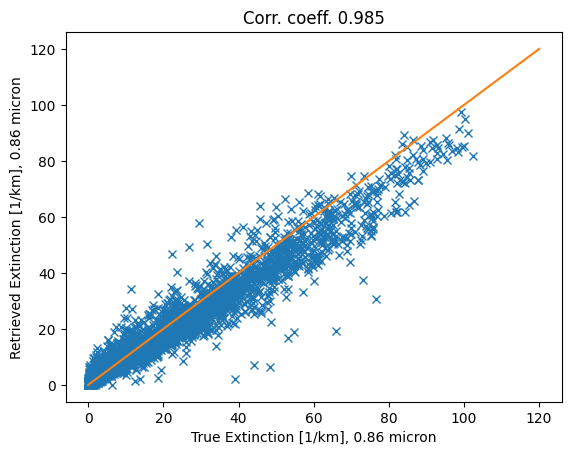

In [16]:
#compare cell averaged extinction on the TRUE grid.
true_geo_extinct = list(solvers.values())[0].medium['cloud']
true_geo_extinct.extinction.data = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)

reference, other = at3d.util.cell_average_comparison(
     true_geo_extinct,
                                   list(solvers_reconstruct.values())[0].medium['cloud'],
                                  'extinction')
py.figure()
py.plot(reference.ravel(),
        other.ravel(),'x')
py.plot([0, 120.0], [0.0, 120.0])
py.xlabel('True Extinction [1/km], 0.86 micron')
py.ylabel('Retrieved Extinction [1/km], 0.86 micron')
py.title('Corr. coeff. %.3f'%np.corrcoef(reference.ravel(), other.ravel())[1, 0])

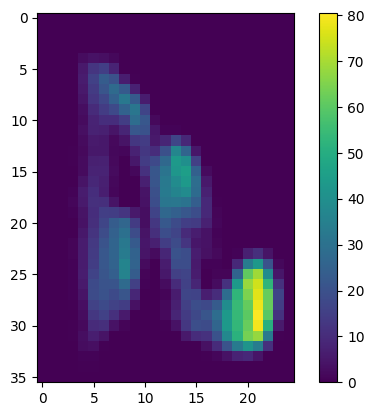

In [17]:
py.figure()
py.imshow(other[12])
py.colorbar()

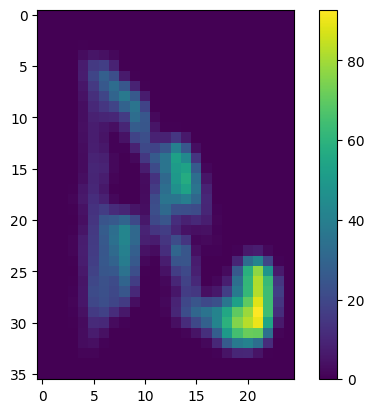

In [18]:
py.figure()
py.imshow(reference[12])
py.colorbar()

(0.0, 22.0)

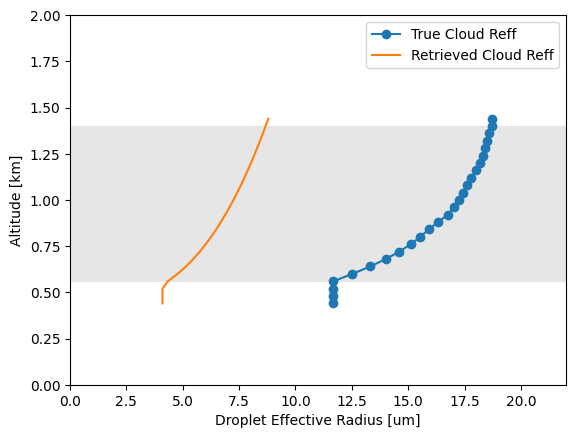

In [19]:
#plot Reff profiles.

#remake the true grid since it was overwritten.
rte_grid2 = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

py.figure()
py.plot(solvers[0.66].medium['cloud'].reff[16,16], rte_grid.z, marker='o', label = 'True Cloud Reff')
py.plot(solvers_reconstruct[0.66].medium['cloud'].reff[16,16], rte_grid2.z, label='Retrieved Cloud Reff')
py.legend()
py.xlabel('Droplet Effective Radius [um]')
py.ylabel('Altitude [km]')
py.fill_between([0,23], CBH, CTH, color='0.9')
py.ylim(0, 2.)
py.xlim(0, 22)

(0.0, 2.0)

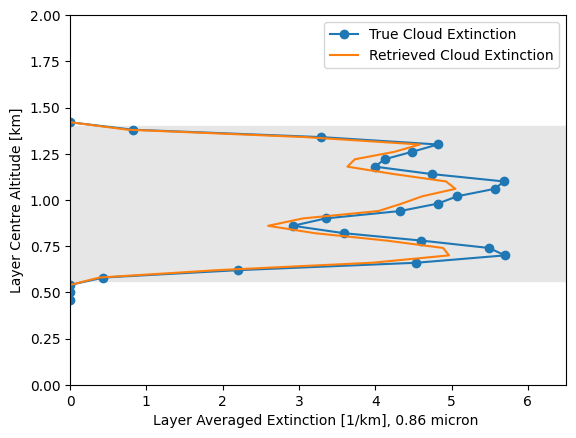

In [20]:
z = 0.5*(rte_grid.z.data[1:] + rte_grid.z.data[:-1])
py.figure()
py.plot(reference.mean(axis=(0,1)), z, marker='o',
       label='True Cloud Extinction')
py.plot(other.mean(axis=(0,1)), z, 
        label='Retrieved Cloud Extinction')
#solvers[0.86].medium['cloud'].extinction.where(mask, np.nan).mean(axis=(0,1)).plot()
py.legend()
py.fill_between([0,6.5], CBH, CTH, color='0.9')
py.xlabel('Layer Averaged Extinction [1/km], 0.86 micron ')
py.ylabel('Layer Centre Altitude [km]')
py.xlim(0, 6.5)
py.ylim(0,2)

In [21]:
cameras = ['DF', 'CF', 'BF', 'AF', 'AN', 'AA', 'BA', 'CA', 'DA']
fig, ax = plt.subplots(2, len(cameras), figsize=(15,3), dpi=200)
for i, (true_im, rec_im) in enumerate(zip(forward_sensors.get_images('MISR'), sensors_dict.get_images('MISR'))):
    #py.figure()
    #image.I.plot(vmax=0.2,vmin=0.0)
    vza = np.mean(np.arccos(true_im.mu.data)/np.pi*180)
    ax[0,i].set_title(f"{cameras[i]}\n{vza:.1f} deg")
    im=ax[1,i].pcolormesh(true_im.x, true_im.y, rec_im.I.data * np.pi, vmin=0, vmax=0.5, shading='auto')
    im1=ax[0,i].pcolormesh(true_im.x, true_im.y, true_im.I.data * np.pi, vmin=0, vmax=0.5, shading='auto')
    ax[0,i].set_xticks([])
    ax[1,i].set_xlabel('x [km]')
cbar1 = plt.colorbar(im1, ax=ax[1,i])
cbar2 = plt.colorbar(im, ax=ax[0,i])
cbar1.set_label('BRF')
cbar2.set_label('BRF')
ax[1,0].set_ylabel('$\mathbf{Estimated}$\ny [km]')
ax[0,0].set_ylabel('$\mathbf{True}$\ny [km]')
plt.tight_layout();
print(np.mean(np.arccos(true_im.mu.data)/np.pi*180))

NameError: name 'plt' is not defined

In [ ]:
import pylab as py
#%matplotlib qt
for image in forward_sensors.get_images('MODIS'):
    py.figure()
    image.I.plot(vmax=0.2,vmin=0.0)

In [ ]:
import pylab as py
#%matplotlib qt
for image1, image2 in zip(sensors_dict.get_images('MISR'),forward_sensors.get_images('MISR')):
    py.figure()
    (image1.I - image2.I).plot(vmax=0.05,vmin=-0.05, cmap='seismic')

In [ ]:
import pylab as py
#%matplotlib qt
for image1, image2 in zip(sensors_dict.get_images('MODIS'),forward_sensors.get_images('MODIS')):
    py.figure()
    (image1.I - image2.I).plot(vmax=0.05,vmin=-0.05, cmap='seismic')

In [ ]:
aero = aerosol_poly_tables[0.86]

In [ ]:
aerosol_mono_table.radius

In [ ]:
radii = np.linspace(0.005, 20, 10000)
n = at3d.size_distribution.lognormal(radii,10,veff=0.1,alpha=None,particle_density=1.0)

In [ ]:
py.figure()
#py.plot(radii, at3d.size_distribution.lognormal(radii,0.2,veff=0.01,alpha=None,particle_density=1.0))
py.plot(radii, at3d.size_distribution.lognormal(radii,6,veff=np.log(2.51),particle_density=1.0))
#py.plot(radii, at3d.size_distribution.lognormal(radii,12,alpha=np.log(2.51),particle_density=1.0))
#py.plot(radii, at3d.size_distribution.lognormal(radii,10,veff=0.2,alpha=None,particle_density=2.0))
py.xscale('log')
py.yscale('log')

In [ ]:
np.log10(2.51)

In [ ]:
n[-500:]

In [ ]:
alpha = np.log(2.51)
distr_width_aerosol = np.exp(alpha**2) - 1
print(alpha, distr_width_aerosol)